# Deep Learning for Computer Vision:  Assignment 1


## Computer Science: COMS W 4995 007


### Due: October 1, 2019

#### Problem 1

You are asked to produce a minumum error rate classifier for a 3-class classification problem. Your feature space is 2-dimensional. Let's say the class conditional density functions (or likelihoods) are known and given by $\rho({\bf x}|y_i)$
where ${\bf x}$ is your feature and $y_i$ specifies the class. Let's also assume that the priors $P(y_i)$ are also given. (Both of these are specified below.) Show the decision regions for each of the three classes. Hint: you can show this by densely generating sample points ${\bf x}_j \in X$ in the feature space, classifying them, and then plotting and coloring them according to their predicted label.

Let the ccds and priors be given as:
    

$$\rho({\bf x}|y_1) \sim N({\bf \mu}_1, \Sigma_1)  \text{ and } P(y_1) = 0.5\,\, \text{ where } \,\, 
{\bf \mu}_1 = \left[\begin{array}{c} 1 \\ 1  \end{array} \right]
\,\, \text{ and } 
\Sigma_1 = \left[\begin{array}{cc} 1 & 0 \\ 0 & 0.5  \end{array} \right] $$


#### $$\rho({\bf x}|y_2) \sim N({\bf \mu}_2, \Sigma_2)  \text{ and } P(y_2) = 0.4\,\, \text{ where } \,\, 
{\bf \mu}_2 = \left[\begin{array}{c} 1 \\ 0  \end{array} \right]
\,\, \text{ and } 
\Sigma_2 = \left[\begin{array}{cc} 0.5 & 0 \\ 0 & 1  \end{array} \right] $$


$$\rho({\bf x}|y_3) \sim N({\bf \mu}_3, \Sigma_3)  \text{ and } P(y_3) = 0.1\,\, \text{ where } \,\, 
{\bf \mu}_3 = \left[\begin{array}{c} 0 \\ -1  \end{array} \right]
\,\, \text{ and } 
\Sigma_3 = \left[\begin{array}{cc} 2.0 & 0 \\ 0 & 0.5  \end{array} \right] $$

Remember all you need to do is to use Bayes theorem to get the expression for $P(y_i|{\bf x})$, then for each sample ${\bf x}_j \in X$ choose the $i$ with the highest aposteriori probability. Do not use any statisical packages to do this other than numpy.

In [268]:
import numpy as np
import random
import matplotlib.pyplot as plt

The equation used for the class conditional probability was for a multivariate gaussian distribution. The equation was found on the following document: http://cs229.stanford.edu/section/gaussians.pdf. The equation is as follows:
$\frac{exp(\frac{−1}{2}(x−μ)^{T}Σ^{−1}(x−μ))}{(2π)^{\frac{n}{2}}|Σ|^{1/2}}$ where n is the number of dimensions (in this case n=2) and x is a column vector.

In [269]:
# Determine the class conditional probability by using the above multivariate normal distribution
def get_class_cond_prob(mean, cov, data_point):
    det=np.linalg.det(cov)
    inv=np.linalg.inv(cov)
    diff=data_point-mean
    numerator = np.matmul(np.matmul(inv, diff.T), diff)
    class_cond = np.exp(-0.5*numerator)/(2*np.pi*(det**0.5))
    return class_cond

In [270]:
# Class statistics
prior_class1 = 0.5
prior_class2 = 0.4
prior_class3 = 0.2

mean_class1 = np.array([1, 1])
mean_class2 = np.array([1, 0])
mean_class3 = np.array([0, -1])

cov_class1 = np.array([[1, 0],[0, 0.5]])
cov_class2 = np.array([[0.5, 0],[0 ,1]])
cov_class3 = np.array([[2.0, 0],[0, 0.5]])

# Given feature space data points, classify each point using maximum a-posterior probability 
# Plot classified points to show boundary lines
def determine_boundaries(data_points):
    class_1 = []
    class_2 = []
    class_3 = []

    # Determine class labeles for the sampled data
    for i in range(len(data_points)):
        data_point=data_points[i]
        # Determine the class conditional probability for each point
        class_1_apos_prob = get_class_cond_prob(mean_class1, cov_class1, data_point)*prior_class1
        class_2_apos_prob = get_class_cond_prob(mean_class2, cov_class2, data_point)*prior_class2
        class_3_apos_prob = get_class_cond_prob(mean_class3, cov_class3, data_point)*prior_class3
        # Classify the point with the class which results in the highest aposterior probability
        class_label = np.argmax([class_1_apos_prob, class_2_apos_prob, class_3_apos_prob])
        if class_label == 0:
            class_1.append(data_point)
        elif class_label == 1:
            class_2.append(data_point)
        else:
            class_3.append(data_point)

    x_1, y_1 = np.array(class_1).T
    x_2, y_2 = np.array(class_2).T
    x_3, y_3 = np.array(class_3).T
    
    fig, axes = plt.subplots(figsize=(9,7))
    plt.scatter(x_1, y_1, c='b', label='class 1')
    plt.scatter(x_2, y_2, c='r', label='class 2')
    plt.scatter(x_3, y_3, c='g', label='class 3')
    plt.xlabel('Feature 1', fontsize=10)
    plt.ylabel('Feature 2', fontsize=10)
    plt.title('Classification Results')
    axes.legend()
    axes.legend(loc=1)
    plt.show()

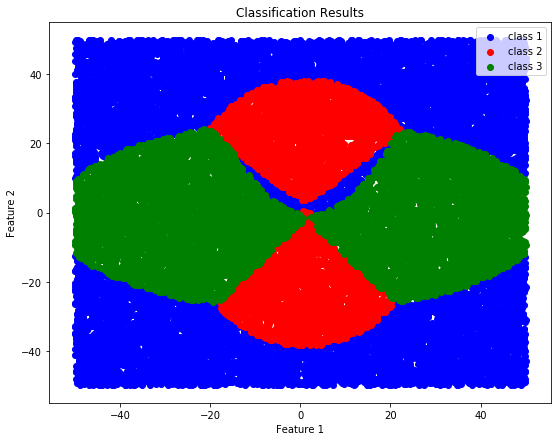

In [271]:
# Set boundaries for feature space to sample
lower_x_bound = -50
lower_y_bound = -50
upper_x_bound = 50
upper_y_bound = 50

# Number of points to be sampled from feature space
num_points = 25000

lower_bounds = [lower_x_bound, lower_y_bound]
upper_bounds = [upper_x_bound, upper_x_bound]

# Sample data from uniformly with the given bounds
data_points = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(num_points,2))

# Classify the sampled data and plot to show class boundaries
determine_boundaries(data_points)

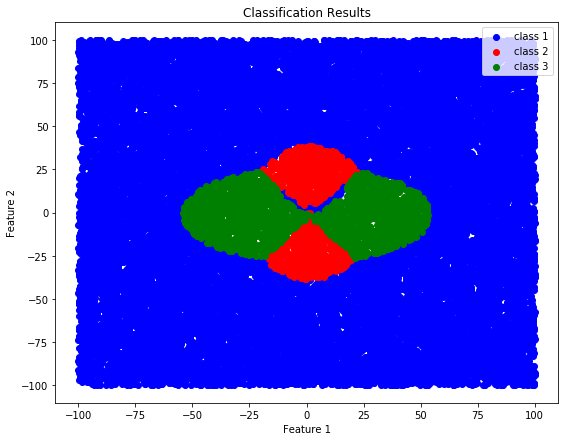

In [272]:
lower_x_bound = -100
lower_y_bound = -100
upper_x_bound = 100
upper_y_bound = 100

num_points = 25000

lower_bounds = [lower_x_bound, lower_y_bound]
upper_bounds = [upper_x_bound, upper_x_bound]

data_points = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(num_points,2))
determine_boundaries(data_points)

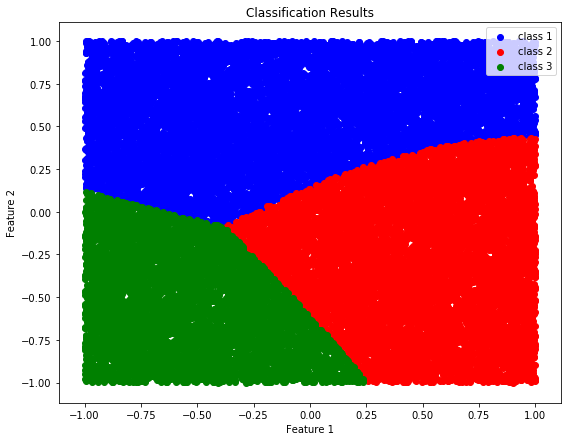

In [273]:
lower_x_bound = -1
lower_y_bound = -1
upper_x_bound = 1
upper_y_bound = 1

num_points = 25000

lower_bounds = [lower_x_bound, lower_y_bound]
upper_bounds = [upper_x_bound, upper_x_bound]

data_points = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(num_points,2))
determine_boundaries(data_points)

#### Problem 2

Implement the Pegasos algorithm for finding a linear SVM classifier which separates the training data generated below. Experiment with three different choices for the regularization parameter and plot the resulting separating plane. Explain how the choice of C effects the resulting solution. Hint: the algorithm might show better convergence if you use the projection normalization step. Also, you can consult with any literature beyond the course notes, but you must write your own code.

In [283]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [284]:
# Let's make up some random data to use to build our SVM classifier
data = pd.DataFrame(np.zeros((500, 3)), columns=['x1', 'x2', 'y'])

for i in range(len(data.index)):
    x1 = random.randint(20,100)
    if np.random.random() > 0.5:
        data.iloc[i,0] = 1.0 * x1 
        data.iloc[i,1] = 0.25 * x1 + 60.0 * (random.random() - 0.5) + 65.0
        data.iloc[i,2] = 1.0
    else:
        data.iloc[i,0] = 1.0 * x1
        data.iloc[i,1] = 0.24 * x1 + 40.0 * (random.random() - 0.5) + 0.0 
        data.iloc[i,2] = -1.0
    
# Add in a stray point
data.iloc[0,0] = 50.0
data.iloc[0,1] = 0.25 * x1 + 25.0
data.iloc[0,2] = 1.0

# Now let's normalize this data.

data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()

data.head()
data.describe()

,x1,x2,y
count,5.000000e+02,5.000000e+02,500.000000
mean,-1.278977e-16,7.105427e-17,-0.024000
std,1.000000e+00,1.000000e+00,1.000713
min,-1.712425e+00,-1.669006e+00,-1.000000
25%,-8.538946e-01,-8.696810e-01,-1.000000
50%,2.609933e-02,-1.943538e-01,-1.000000
75%,8.309718e-01,9.247507e-01,1.000000
max,1.721697e+00,1.958075e+00,1.000000


In [285]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)

In [286]:
# Sloppy function for plotting our data
def plot_data(X, y):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y > 0
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='-1')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Training Data')
    plt.show()

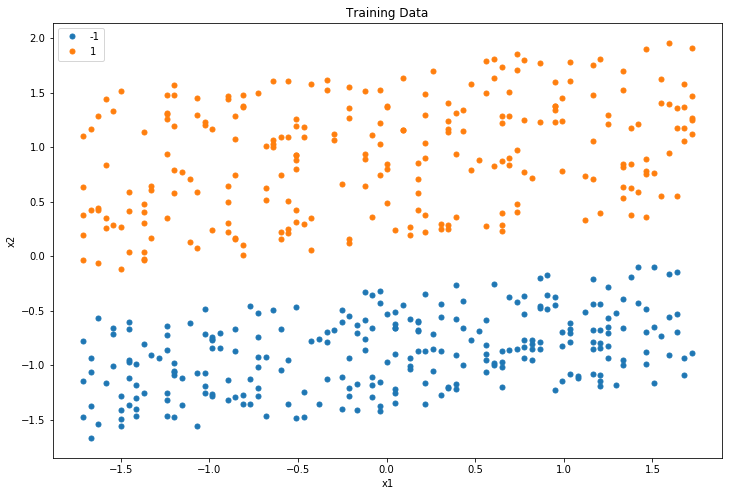

In [287]:
plot_data(X,y)

In [288]:
def get_weights(T, X, reg_param):
    # Add additional value for b as wx + b = [w0 w1 b]*[x1 x2 1].T 
    # Therefore, can be treated as a third constant feature
    w = np.array([0, 0, 0])
    X = np.column_stack((X, np.ones((len(X), 1))))
    for t in range(T):
        # Random index points which are distributed uniformly
        i = np.random.randint(0, len(X) - 1)
        step= t + 1
        learning_rate = 1/(step*reg_param)
        val = y[i] * np.dot(w, X[i].T)
        if val < 1:
            w = (1 - learning_rate*reg_param)*w + learning_rate*np.dot(y[i], X[i])
        else:
            w = (1 - learning_rate*reg_param)*w 
        norm = np.linalg.norm(w, ord=2)
        w = min(1, (1/np.sqrt(reg_param))/norm)*w
    return w

In [289]:
def plot_boundary(X, y, w, reg_param):  
    class_A_indices = [i for i in range(len(X)) if y[i] > 0]
    class_B_indices = [i for i in range(len(X)) if y[i] < 0]
    
    class_A_points = X[class_A_indices]
    class_B_points = X[class_B_indices]
    
    # Training data
    x_A, y_A = np.array(class_A_points).T
    x_B, y_B = np.array(class_B_points).T
    
    # Plot boundaries
    min_point = min(min(x_A), min(x_B))
    max_point = max(max(x_A), max(x_B))
    
    points = np.linspace(min_point, max_point, 100)
    
    # As w is perpendicular to the boundary, find negative reciprocal to get slope of orthog.
    slope = -w[0, 0]/w[0, 1]

    # Following the equation of a line: Ax1 + Bx2 + bias = 0 where A and B are the components of the weight vector
    # For y = mx + b, find b or the y intercept by setting x to 0. Therefore, y intercept is
    #-bias/(B) i.e the bias divided by the second component of the weight vector
    boundary = [slope*points - w[0, 2]/w[0, 1]]
    
    # For the support vectors, they have the same slope as the boundary. However, need to find their y intercepts
    # With +/-1, the equation of the line becomes Ax1 + Bx2 + bias = 1 (or -1). 
    # Again, finding the y intercept, we get x2 = (1 - bias)/B and (-1 - bias)/B for the two lines
    margin_A = [slope*point - 1/w[0, 1] - w[0,2]/w[0,1] for point in points]
    margin_B = [slope*point + 1/w[0, 1] - w[0,2]/w[0,1] for point in points]
    
    plt.subplots(figsize=(13, 7))
    
    plt.scatter(x_A, y_A, c='b')
    plt.scatter(x_B, y_B, c='r')
    
    plt.plot(points, np.array(boundary).T)
    plt.plot(points, np.array(margin_A).T)
    plt.plot(points, np.array(margin_B).T)
    
    plt.xlabel('Feature 1', fontsize=10)
    plt.ylabel('Feature 2', fontsize=10)
    plt.title('Boundary for Regularization Parameter={}'.format(reg_param))
    plt.show()

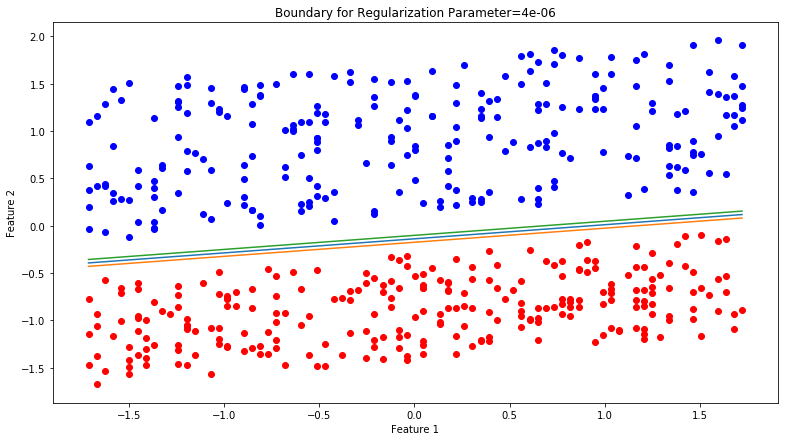

In [290]:
T = 50000
N = len(X)
C = 1000
reg_param = 2/(N*C)
w = get_weights(T, X, reg_param)
plot_boundary(X, y, w, reg_param)

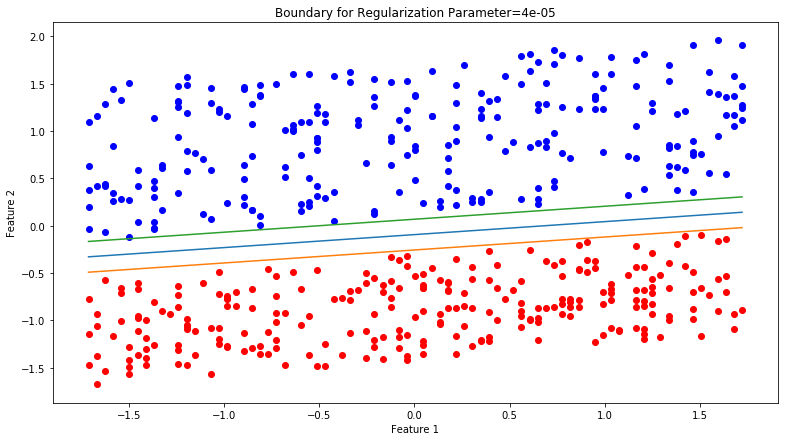

In [291]:
C = 100
reg_param = 2/(N*C)
w = get_weights(T, X, reg_param)
plot_boundary(X, y, w, reg_param)

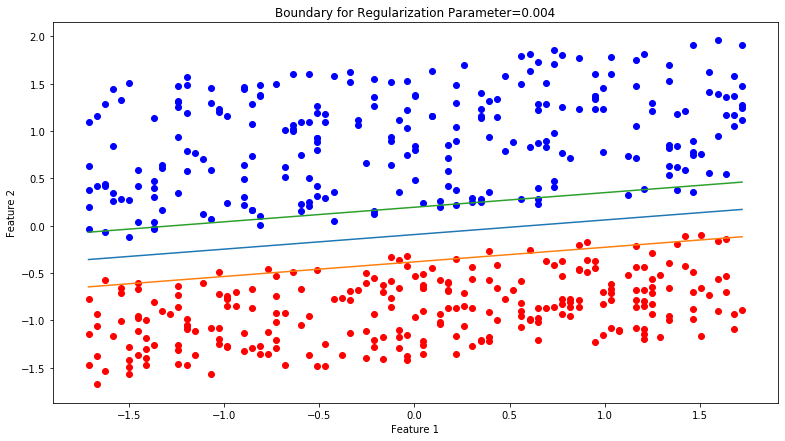

In [292]:
C = 1
reg_param = 2/(N*C)
w = get_weights(T, X, reg_param)
plot_boundary(X, y, w, reg_param)

Based on the plots above, it can be seen that as the value of C is decreased, the margin becomes larger whereas for the case where C is large (such as in the case of C=1000), the margin is quite small. This is because the value of C determines how much error is allowed by our support vectors or how much "wiggle room" there is when dealing with stray points and outliers. The value of C impacts the resulting solution by determining the amount of violation that is permitted when trying to maximize the margin between the two classes. In the case of the data generated above, there may be a data point which is closer to the class which it does not belong to. For this data point and other outliers, having a very small margin due to the large C may result in poorer performance (poorer generalization) as the model does not allow any error and our soft margins essentially lose their permitted wiggle room. In contrast, when C is smaller, some error is allowed, allowing us to better classify outliers and stray points as we are permitted to have a linear classifier for data that is not exactly linearly seprable due to outliers, by allowing these outliers to fall into the margin.